<a href="https://colab.research.google.com/github/atmark-techno/armadillo-iot-g4_model_zoo/blob/main/GoogleColabNotebooks/PoseEstimation_OperationCheck.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 準備

## モデルのダウンロード

ダウンロードする代わりに、PoseEstimation_Quantizeで作成したモデルをposenet.tfliteのファイル名でアップロードすることで、そのモデルを使用できます。

In [1]:
%%bash
wget https://download.atmark-techno.com/armadillo-iot-g4/example/sample-models/posenet.tflite

--2022-08-17 04:36:06--  https://download.atmark-techno.com/armadillo-iot-g4/example/sample-models/posenet.tflite
Resolving download.atmark-techno.com (download.atmark-techno.com)... 221.114.106.147
Connecting to download.atmark-techno.com (download.atmark-techno.com)|221.114.106.147|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24704480 (24M)
Saving to: ‘posenet.tflite’

     0K .......... .......... .......... .......... ..........  0%  157K 2m33s
    50K .......... .......... .......... .......... ..........  0%  315K 1m55s
   100K .......... .......... .......... .......... ..........  0% 33.6M 76s
   150K .......... .......... .......... .......... ..........  0% 89.7M 57s
   200K .......... .......... .......... .......... ..........  1%  316K 61s
   250K .......... .......... .......... .......... ..........  1%  164M 51s
   300K .......... .......... .......... .......... ..........  1%  211M 43s
   350K .......... .......... .......... .......... ..

## テスト画像のダウンロード

In [2]:
# テスト画像をtest.jpgという名前で保存します。
%%bash
wget "https://unsplash.com/photos/OFyh9TpMyM8/download?ixid=MnwxMjA3fDB8MXxhbGx8fHx8fHx8fHwxNjYwNjExMDAz&force=true&w=1920" -O test.jpg

--2022-08-17 04:36:09--  https://unsplash.com/photos/OFyh9TpMyM8/download?ixid=MnwxMjA3fDB8MXxhbGx8fHx8fHx8fHwxNjYwNjExMDAz&force=true&w=1920
Resolving unsplash.com (unsplash.com)... 151.101.129.181, 151.101.1.181, 151.101.65.181, ...
Connecting to unsplash.com (unsplash.com)|151.101.129.181|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://images.unsplash.com/photo-1541625602330-2277a4c46182?ixlib=rb-1.2.1&dl=coen-van-de-broek-OFyh9TpMyM8-unsplash.jpg&w=1920&q=80&fm=jpg&crop=entropy&cs=tinysrgb [following]
--2022-08-17 04:36:09--  https://images.unsplash.com/photo-1541625602330-2277a4c46182?ixlib=rb-1.2.1&dl=coen-van-de-broek-OFyh9TpMyM8-unsplash.jpg&w=1920&q=80&fm=jpg&crop=entropy&cs=tinysrgb
Resolving images.unsplash.com (images.unsplash.com)... 146.75.34.208, 2a04:4e42:79::720
Connecting to images.unsplash.com (images.unsplash.com)|146.75.34.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 348978 (341K) [image/jpeg]


## 必要なファイルの取得

In [3]:
%%bash
git clone https://github.com/rwightman/posenet-python.git
cp -r posenet-python/posenet ./

Cloning into 'posenet-python'...


## テストコード

### ライブラリのインポート

In [4]:
from tensorflow.lite.python.interpreter import Interpreter # Armadillo-IoT ゲートウェイ G4 実機上では、"from tflite_runtime import Interpreter" としてインポートしてください。
import cv2
import numpy as np
import posenet
from google.colab.patches import cv2_imshow # Google colab上でcv2画像を表示するために必要なライブラリ

### interpreterの準備

In [5]:
interpreter = Interpreter('posenet.tflite')
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)
print(output_details)

_, i_height, i_width, _ = input_details[0]['shape']

[{'name': 'image', 'index': 198, 'shape': array([  1, 225, 225,   3], dtype=int32), 'shape_signature': array([  1, 225, 225,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'resnet_v1_50/displacement_bwd_2/BiasAdd/conv', 'index': 199, 'shape': array([ 1, 15, 15, 32], dtype=int32), 'shape_signature': array([ 1, 15, 15, 32], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'resnet_v1_50/displacement_fwd_2/BiasAdd/conv', 'index': 200, 'shape': array([ 1, 15, 15, 32], dtype=int32), 'shape_signature': array([ 1, 15, 15, 32], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantiz

### テスト画像を読み込み、モデルに入力する形に整形する

In [6]:
img = cv2.imread('test.jpg')
input_image = cv2.resize(img, (i_height, i_width))
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB).astype(np.float32)
input_image = np.expand_dims(input_image, 0).astype(np.float32)

# 推論した各点の座標を元画像に描画するためにscaleを取っておく
scale = np.array([img.shape[0] / i_height, img.shape[1] / i_width])

### 推論実行

In [7]:
interpreter.set_tensor(input_details[0]['index'], input_image)
interpreter.invoke()

### 推論結果を抽出

In [8]:
heatmaps_result = interpreter.get_tensor(output_details[3]['index'])
offsets_result = interpreter.get_tensor(output_details[2]['index'])
displacement_fwd_result = interpreter.get_tensor(output_details[1]['index'])
displacement_bwd_result = interpreter.get_tensor(output_details[0]['index'])

In [9]:
pose_scores, keypoint_scores, keypoint_coords = \
    posenet.decode_multi.decode_multiple_poses(
    heatmaps_result.squeeze(axis=0),
    offsets_result.squeeze(axis=0),
    displacement_fwd_result.squeeze(axis=0),
    displacement_bwd_result.squeeze(axis=0),
    output_stride=16,
    max_pose_detections=10,
    min_pose_score=0.15
)

### 座標のスケールを変換

In [10]:
keypoint_coords *= scale

### 各キーポイントを描画、表示

In [11]:
frame = posenet.draw_skel_and_kp(
    img,
    pose_scores,
    keypoint_scores,
    keypoint_coords,
    min_pose_score=0.30,
    min_part_score=0.1
)

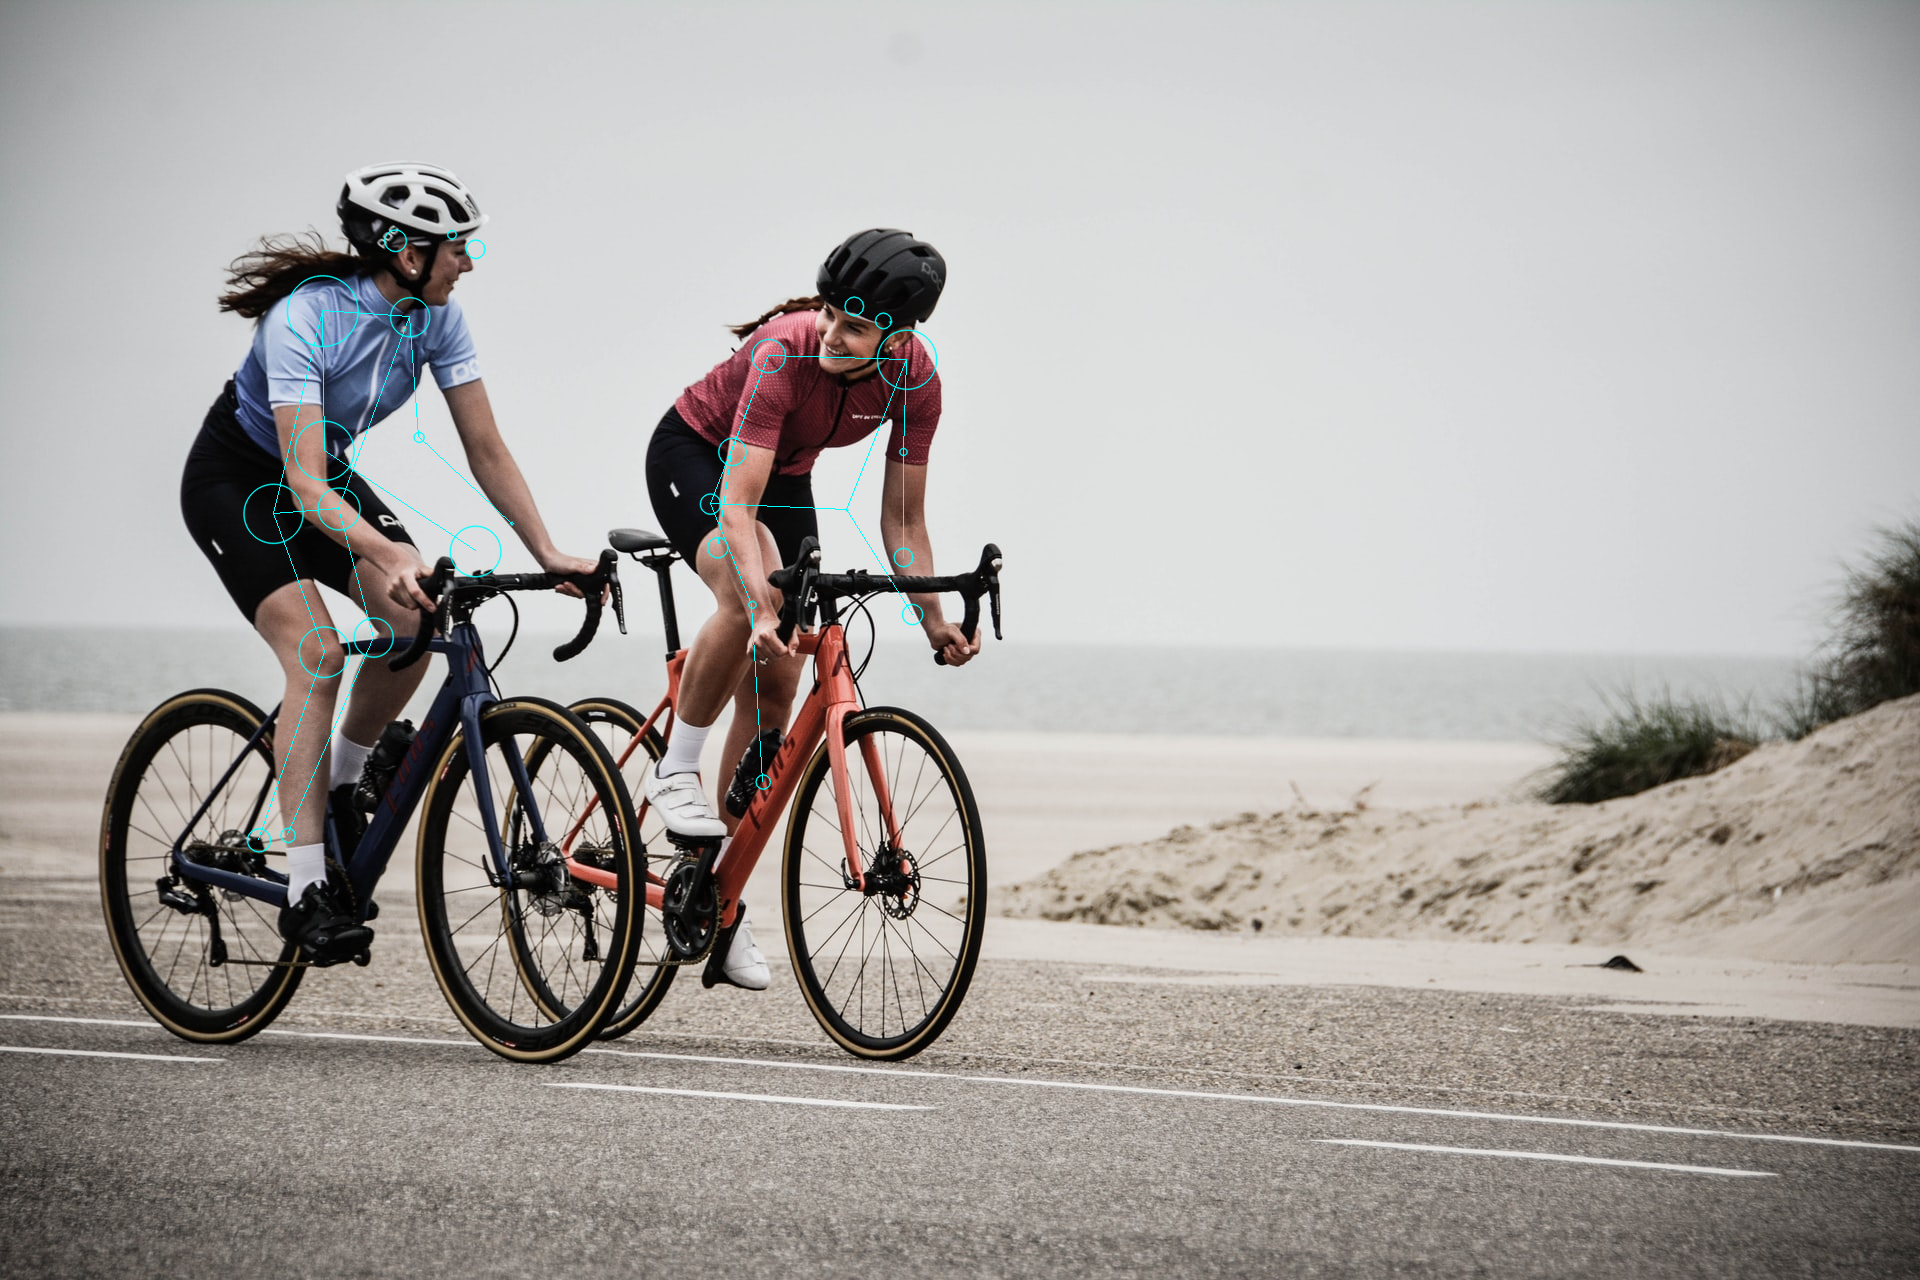

In [12]:
cv2_imshow(frame)